In [181]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

SAMPLE_ELOS = [1000, 1200, 1500, 1800, 2000, 2200]

In [182]:
df = pd.read_parquet("../data/stats_dataset.parquet")
len(df)

126

In [183]:
df.describe()

,games_count,global_avg_elo,global_winrate,delta,fragility_score,variance,score,winrate_1000,group_count_1000,score_1000,...,score_1500,winrate_1800,group_count_1800,score_1800,winrate_2000,group_count_2000,score_2000,winrate_2200,group_count_2200,score_2200
count,126.000000,126.000000,126.000000,126.000000,126.000000,1.260000e+02,126.000000,125.000000,125.00000,126.000000,...,126.000000,126.000000,126.000000,126.000000,125.000000,125.000000,126.000000,123.000000,123.000000,126.000000
mean,184.777778,1501.147853,0.503647,-10.063492,0.413680,4.145065e+04,-10.063492,0.502842,36.42400,-10.063492,...,-10.063492,0.503317,55.476190,-10.063492,0.493931,30.448000,-10.063492,0.471677,11.869919,-10.063492
std,93.492921,155.102765,0.070545,23.990247,0.256360,2.804663e+05,23.990247,0.157817,28.20783,23.990247,...,23.990247,0.090739,33.288969,23.990247,0.111438,26.736907,23.990247,0.283327,16.574699,23.990247
min,100.000000,1214.259259,0.285714,-185.000000,0.035385,9.572016e+00,-185.000000,0.000000,1.00000,-185.000000,...,-185.000000,0.306818,7.000000,-185.000000,0.166667,1.000000,-185.000000,0.000000,1.000000,-185.000000
25%,124.000000,1399.707542,0.459342,-13.000000,0.220135,8.342410e+01,-13.000000,0.425532,18.00000,-13.000000,...,-13.000000,0.451613,33.000000,-13.000000,0.428571,14.000000,-13.000000,0.333333,3.000000,-13.000000
50%,151.000000,1452.633591,0.511866,-6.000000,0.338377,3.692428e+02,-6.000000,0.513514,28.00000,-6.000000,...,-6.000000,0.496727,47.000000,-6.000000,0.500000,21.000000,-6.000000,0.500000,5.000000,-6.000000
75%,204.000000,1553.838094,0.544075,0.000000,0.511290,5.740141e+03,0.000000,0.594595,50.00000,0.000000,...,0.000000,0.558889,72.000000,0.000000,0.562500,40.000000,0.000000,0.600000,12.000000,0.000000
max,621.000000,1989.342857,0.664286,31.000000,1.407527,2.242195e+06,31.000000,1.000000,135.00000,31.000000,...,31.000000,0.818182,245.000000,31.000000,1.000000,181.000000,31.000000,1.000000,89.000000,31.000000


In [184]:
results = []
grouped = df.groupby("fen").first().reset_index()

for elo in SAMPLE_ELOS:
    is_best_col = f"is_best_{elo}"
    is_engine_col = f"is_engine_best_{elo}"
    is_top3_col = f"is_top3_{elo}"
    is_engine_top3_col = f"is_engine_top3_{elo}"
    # is_frag_col = f"is_frag_best_{elo}"
    # is_delta_col = f"is_delta_best_{elo}"
    # is_mix_col = f"is_mix_best_{elo}"

    avg_is_best = grouped[is_best_col].mean(skipna=True)
    avg_is_engine_best = grouped[is_engine_col].mean(skipna=True)
    avg_is_top3_best = grouped[is_top3_col].mean(skipna=True)
    avg_is_engine_top3_best = grouped[is_engine_top3_col].mean(skipna=True)
    # avg_is_frag_best = grouped[is_frag_col].mean()
    # avg_is_delta_best = grouped[is_delta_col].mean()
    # avg_is_mix_best = grouped[is_mix_col].mean()

    results.append({
        "elo": elo,
        "avg_is_best": avg_is_best,
        "avg_is_engine_best": avg_is_engine_best,
        "avg_is_top3": avg_is_top3_best,
        "avg_is_engine_top3": avg_is_engine_top3_best,
        # "avg_is_frag_best": avg_is_frag_best,
        # "avg_is_delta_best": avg_is_delta_best,
        # "avg_is_mix_best": avg_is_mix_best,
    })

pd.DataFrame(results)

,elo,avg_is_best,avg_is_engine_best,avg_is_top3,avg_is_engine_top3
0,1000,0.938272,0.941176,1.0,0.980392
1,1200,0.950000,0.965517,1.0,0.982759
2,1500,0.935780,0.952381,1.0,1.000000
3,1800,0.916667,0.936508,1.0,0.984127
4,2000,0.951613,0.972222,1.0,1.000000
5,2200,0.869565,0.916667,1.0,1.000000


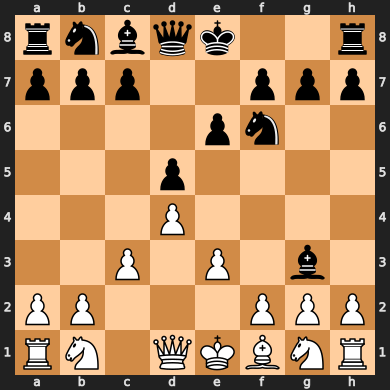

In [185]:
# filtered_df = df[(df["is_top3_1500"] == True) & (df["is_engine_top3_1500"] == False)]
random_fen = df["fen"].sample(1).iloc[0]
filtered = df[df["fen"] == random_fen]
chess.Board(random_fen)

In [186]:
filtered.drop("fen", axis=1).set_index('next_move').T

next_move,h2g3
games_count,168
global_avg_elo,1615.922619
global_winrate,0.511905
engine_move,h2g3
delta,2.0
...,...
recommended_move_2200,h2g3
is_best_2200,True
is_engine_best_2200,True
is_top3_2200,True


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fen                    126 non-null    object 
 1   next_move              126 non-null    object 
 2   games_count            126 non-null    int64  
 3   global_avg_elo         126 non-null    float64
 4   global_winrate         126 non-null    float64
 5   engine_move            126 non-null    object 
 6   delta                  126 non-null    float64
 7   fragility_score        126 non-null    float64
 8   variance               126 non-null    float64
 9   score                  126 non-null    float64
 10  winrate_1000           125 non-null    float64
 11  group_count_1000       125 non-null    float64
 12  historical_best_1000   126 non-null    object 
 13  score_1000             126 non-null    float64
 14  recommended_move_1000  126 non-null    object 
 15  is_bes

In [188]:
df["f_cross_d"] = df["fragility_score"] * df["delta"]
df["f_cross_v"] = df["fragility_score"] * df["variance"]
df["d_cross_v"] = df["delta"] * df["variance"]

selected_features = ["fragility_score", "delta", "variance", "f_cross_d", "f_cross_v", "d_cross_v"]
X = df[selected_features]
y = df["is_best_1500"].fillna(True) # quatschig noch

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [189]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log:.3f}")

Logistic Regression Accuracy: 0.875


In [190]:
print("Logistic Regression Coefficients:")
for feature, coef in zip(selected_features, log_model.coef_[0]):
    print(f"{feature}: {coef:.3f}")

Logistic Regression Coefficients:
fragility_score: -0.575
delta: -0.265
variance: 0.078
f_cross_d: 0.411
f_cross_v: -0.064
d_cross_v: -0.109


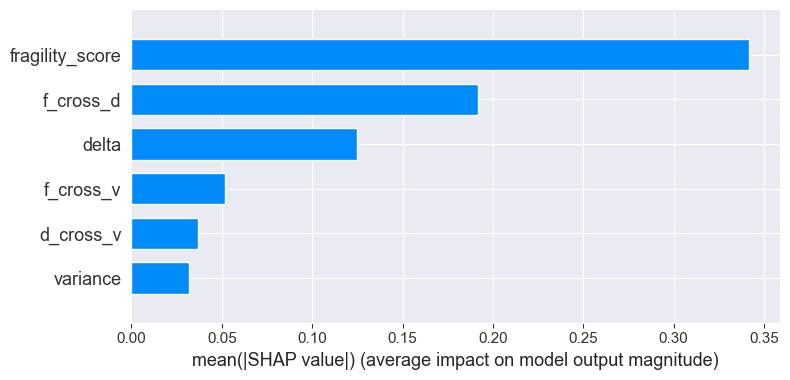

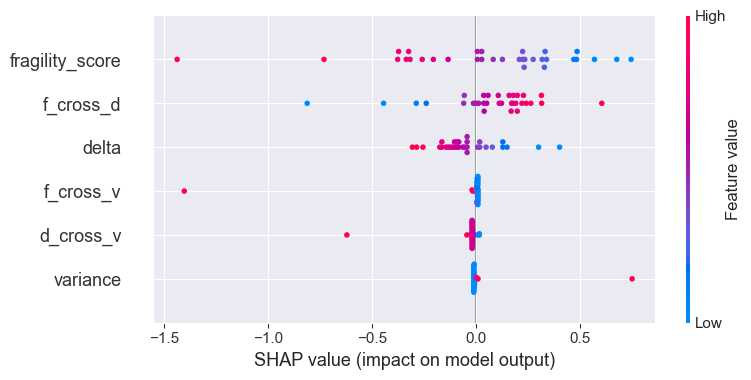

In [191]:
explainer_log = shap.Explainer(log_model, X_train_scaled)
shap_values_log = explainer_log(X_test_scaled)
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_log, features=X_test, feature_names=selected_features, show=True)

In [192]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nXGBoost Accuracy: {acc_xgb:.3f}")


XGBoost Accuracy: 0.844


C:\Users\Philipp\Documents\Code\chess\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:52:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


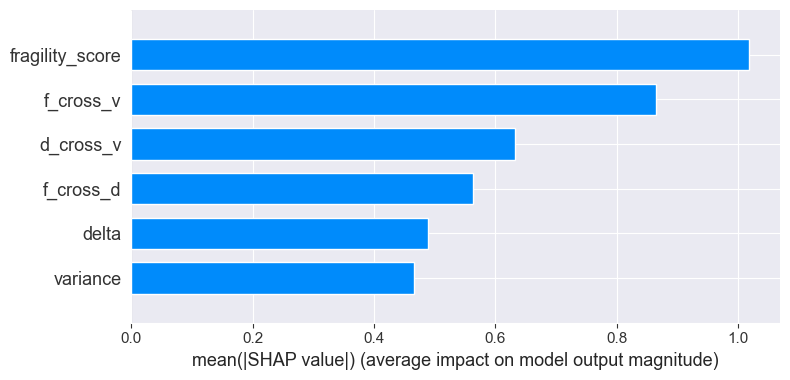

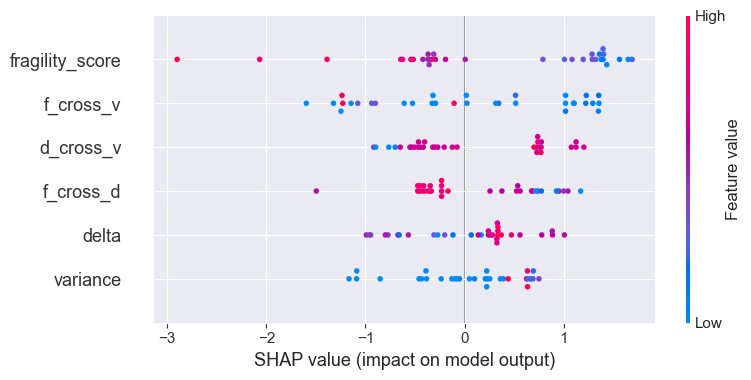

In [193]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, plot_type="bar")
shap.summary_plot(shap_values_xgb, features=X_test, feature_names=selected_features, show=True)

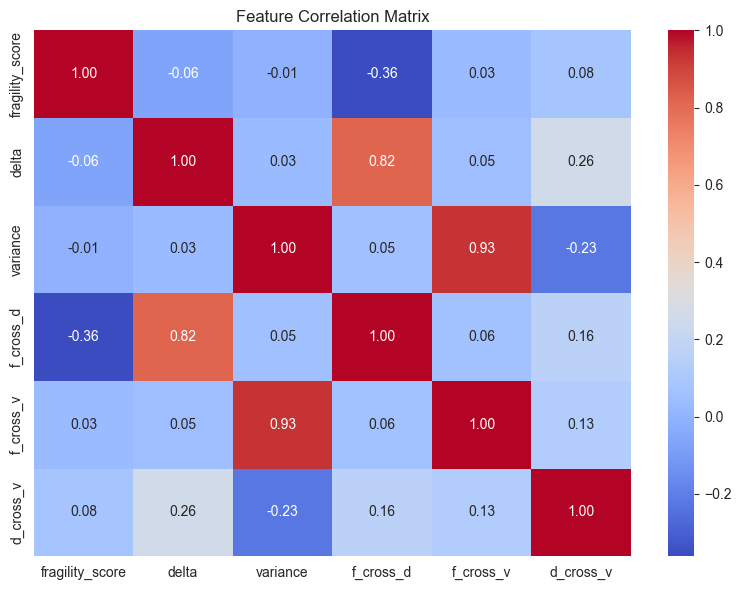

In [194]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()